In [1]:
import math
import os 
import random
import warnings
from datetime import datetime, timedelta
import sys
sys.path.insert(1, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pecnet as pc

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras import Input
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed, Dropout

print(tf.config.list_physical_devices('GPU'))

warnings.filterwarnings(action='ignore', message='Mean of empty slice')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

start = np.datetime64('2001-12-24')  # observed data's time range (for efd)
end = np.datetime64('2012-12-31')    

DATA_FOLDER = "../"+"data/"
STATION_NAME= "34_YSL_HVHO_PROB"


#This is for getting the same results. 
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds(42)

def read(station, start, end):
    if isinstance(start, datetime):
        start = np.datetime64(start)
    if isinstance(end, datetime):
        end = np.datetime64(end)

    path = f'{station}_1min.dat'
    with open(path, "rb") as file:
        file.seek(int((start-np.datetime64('2000-01-01'))/np.timedelta64(1, 'm'))*4)
        minutes = int((end-start)/np.timedelta64(1, 'm'))
        data = np.frombuffer(file.read(minutes*4), np.float32)
    times = np.arange(start, end, np.timedelta64(1, 'm'))
    return times, data

In [3]:
df_collection_efd_energy=pd.DataFrame()

timesSignal, dataSignal = read(DATA_FOLDER + STATION_NAME, start, end)
efd = pd.DataFrame({"value":dataSignal}, index=timesSignal)

energy_release = pd.read_csv(DATA_FOLDER+"energy_release.csv", index_col=0,parse_dates=[0],dayfirst=True).fillna(0).rename_axis("date") #between 2002-2013 years 
#each value keeps next sevendays' energy release mean.(this day+next six days)
energy_release_weekly = pc.rolling_op(energy_release["E_daily"].to_numpy().flatten(), 7,np.nanmean,False) #last value=2012-12-31


day_group = efd.groupby(pd.Grouper(freq='1d', label='right', closed='right')) # groups 1d. intervals of efd as one elem.
daily_mean_efd = day_group.mean() # each group 's mean (ignores nan on default) 
#each value keeps eight day mean efd.                               
eightday_mean_efd = pc.rolling_op(daily_mean_efd.to_numpy().flatten(),8,np.nanmean,False)[:-7] # up to 1 index before the last energy_release date

# In same date index: ER has next seven days mean(date is included) EFD has previous 8 days mean(date is not included) 
df_collection_efd_energy=pd.DataFrame({"EFD":eightday_mean_efd,"ER":energy_release_weekly},index=energy_release.index[:-6]).dropna()

print("NoNanDataLength",len(df_collection_efd_energy))

NoNanDataLength 3997


In [4]:
#InputData will be redimensionalized with sliding window  like (,8) and sent to the network

windowed_efd = pc.get_rolling_windows(df_collection_efd_energy["EFD"].values, 8,fill=False)
print(windowed_efd.shape)
print(windowed_efd[0],"\n",windowed_efd[-1])


input_train_data, input_test_data = train_test_split(windowed_efd, test_size=0.2,shuffle=False)

shifted_output_data=df_collection_efd_energy["ER"][7:].values # due to windowization, energy release should be shifted
output_train_data=shifted_output_data[:len(input_train_data)]
output_test_data=shifted_output_data[len(input_train_data):]


print("InputTrainSize:",len(input_train_data),"InputTestSize:",len(input_test_data))
print("InputTrainShape:",input_train_data.shape,"InputTestShape:",input_test_data.shape)
print("OutputTrainSize:",len(output_train_data),"OutputTestSize:",len(output_test_data))
print("OutputTrainShape:",output_train_data.shape,"OutputTestShape:",output_test_data.shape)


(3990, 8)
[12676.949 12676.949 12668.769 12668.499 12665.537 12579.949 12572.709
 12570.595] 
 [6038.3877 5893.961  5944.6626 6004.871  5945.4785 5786.6533 5707.5586
 5797.807 ]
InputTrainSize: 3192 InputTestSize: 798
InputTrainShape: (3192, 8) InputTestShape: (798, 8)
OutputTrainSize: 3192 OutputTestSize: 798
OutputTrainShape: (3192,) OutputTestShape: (798,)


In [5]:
#input-output  min-max normalization
scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

scaled_input_train = scaler.fit_transform(input_train_data)
scaled_output_train = scaler2.fit_transform(output_train_data.reshape(-1,1)) #makes it a column vector


scaled_input_test = scaler.transform(input_test_data)
scaled_output_test = scaler2.transform(output_test_data.reshape(-1,1))


orig_list=df_collection_efd_energy["ER"].values

zero_count=0
for elem in orig_list:
    if elem<1:
        zero_count+=1
print("Zero number : ", zero_count)
print("Zero % : ",100*zero_count/len(orig_list))

Zero number :  8
Zero % :  0.20015011258443832


In [6]:
#LSTM MODEL ARCHITECTURE

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_lstm=Sequential()

model_lstm.add(LSTM(units=32, return_sequences=True, input_shape=(scaled_input_train.shape[1],1)))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=128, return_sequences=True))
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(units=64,return_sequences=True))
model_lstm.add(Dropout(0.1))

model_lstm.add(LSTM(units=32))
model_lstm.add(Dropout(0.1))

model_lstm.add(Dense(units=1))


model_lstm.compile(optimizer=optimizer,loss='mean_squared_error')

print(model_lstm.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 8, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 64)             24832     
                                                                 
 dropout_1 (Dropout)         (None, 8, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 8, 128)            98816     
                                                                 
 dropout_2 (Dropout)         (None, 8, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 8, 64)             4

In [7]:
#TRAINING WITH THE LSTM MODEL

inf=model_lstm.fit(scaled_input_train,scaled_output_train,validation_split = 0.1,epochs=3000,batch_size=64,shuffle=False,use_multiprocessing=True)

Epoch 1/3000
45/45 [==============================] - 13s 59ms/step - loss: 0.0115 - val_loss: 0.0062
Epoch 2/3000
45/45 [==============================] - 1s 19ms/step - loss: 0.0091 - val_loss: 0.0045
Epoch 3/3000
45/45 [==============================] - 1s 17ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 4/3000
45/45 [==============================] - 1s 18ms/step - loss: 0.0086 - val_loss: 0.0038
Epoch 5/3000
45/45 [==============================] - 1s 17ms/step - loss: 0.0086 - val_loss: 0.0035
Epoch 6/3000
45/45 [==============================] - 1s 18ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 7/3000
45/45 [==============================] - 1s 17ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 8/3000
45/45 [==============================] - 1s 17ms/step - loss: 0.0085 - val_loss: 0.0032
Epoch 9/3000
45/45 [==============================] - 1s 17ms/step - loss: 0.0085 - val_loss: 0.0030
Epoch 10/3000
45/45 [==============================] - 1s 17ms/step - loss: 0.0084 - val_l

In [8]:
# MODEL LOSS/EVALUATIONS/PREDICTIONS

def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    #discarding 0 values and regarding predictions for clear rmspe--->how many?
    index_list, = np.where(np.isclose(y_true, 0)) # floating-point

    y_true=np.delete(y_true,index_list)
    y_pred=np.delete(y_pred,index_list)
    
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

trainPredict = model_lstm.predict(scaled_input_train)
testPredict = model_lstm.predict(scaled_input_test)

print("")
print("scaled ---> output train  at : ",0," ",scaled_output_train[0],"---> train_predict: ",trainPredict[0])
print("scaled ---> output test at : ",0," ",scaled_output_test[0],"---> test_predict: ",testPredict[0])

trainPredict=scaler2.inverse_transform(trainPredict)
testPredict=scaler2.inverse_transform(testPredict)

print("inverse trans. ---> output train at : ",0," ",output_train_data[0],"---> train_predict: ",trainPredict[0])
print("inverse trans. ---> output test at : ",0," ",output_test_data[0],"---> test_predict: ",testPredict[0])

# calculate root mean squared error and r2score
train_RMSE_score = np.sqrt(mean_squared_error(output_train_data, trainPredict))
train_RMSPE_score = rmspe(output_train_data,trainPredict)
train_R2_score = r2_score(output_train_data, trainPredict)


print("")
print('Train Score: %.2f RMSE' % (train_RMSE_score))
print('Train Score: %.2f RMSPE' % (train_RMSPE_score))
print('Train Score: %.2f R2' % (train_R2_score))
print("")

test_RMSE_score = np.sqrt(mean_squared_error(output_test_data, testPredict))
test_R2_score = r2_score(output_test_data, testPredict)
test_RMSPE_score = rmspe(output_test_data, testPredict)

print('Test Score: %.2f RMSE' % (test_RMSE_score))
print('Test Score: %.2f RMSPE' % (test_RMSPE_score))
print('Test Score: %.2f R2' % (test_R2_score))

25/25 [==============================] - 0s 8ms/step

scaled ---> output train  at :  0   [0.21135856] ---> train_predict:  [0.2214409]
scaled ---> output test at :  0   [0.17277206] ---> test_predict:  [0.17390177]
inverse trans. ---> output train at :  0   539.3192811857143 ---> train_predict:  [565.0462]
inverse trans. ---> output test at :  0   440.85891791428577 ---> test_predict:  [443.74158]

Train Score: 195.23 RMSE
Train Score: 0.64 RMSPE
Train Score: 0.21 R2

Test Score: 242.10 RMSE
Test Score: 0.55 RMSPE
Test Score: -0.33 R2


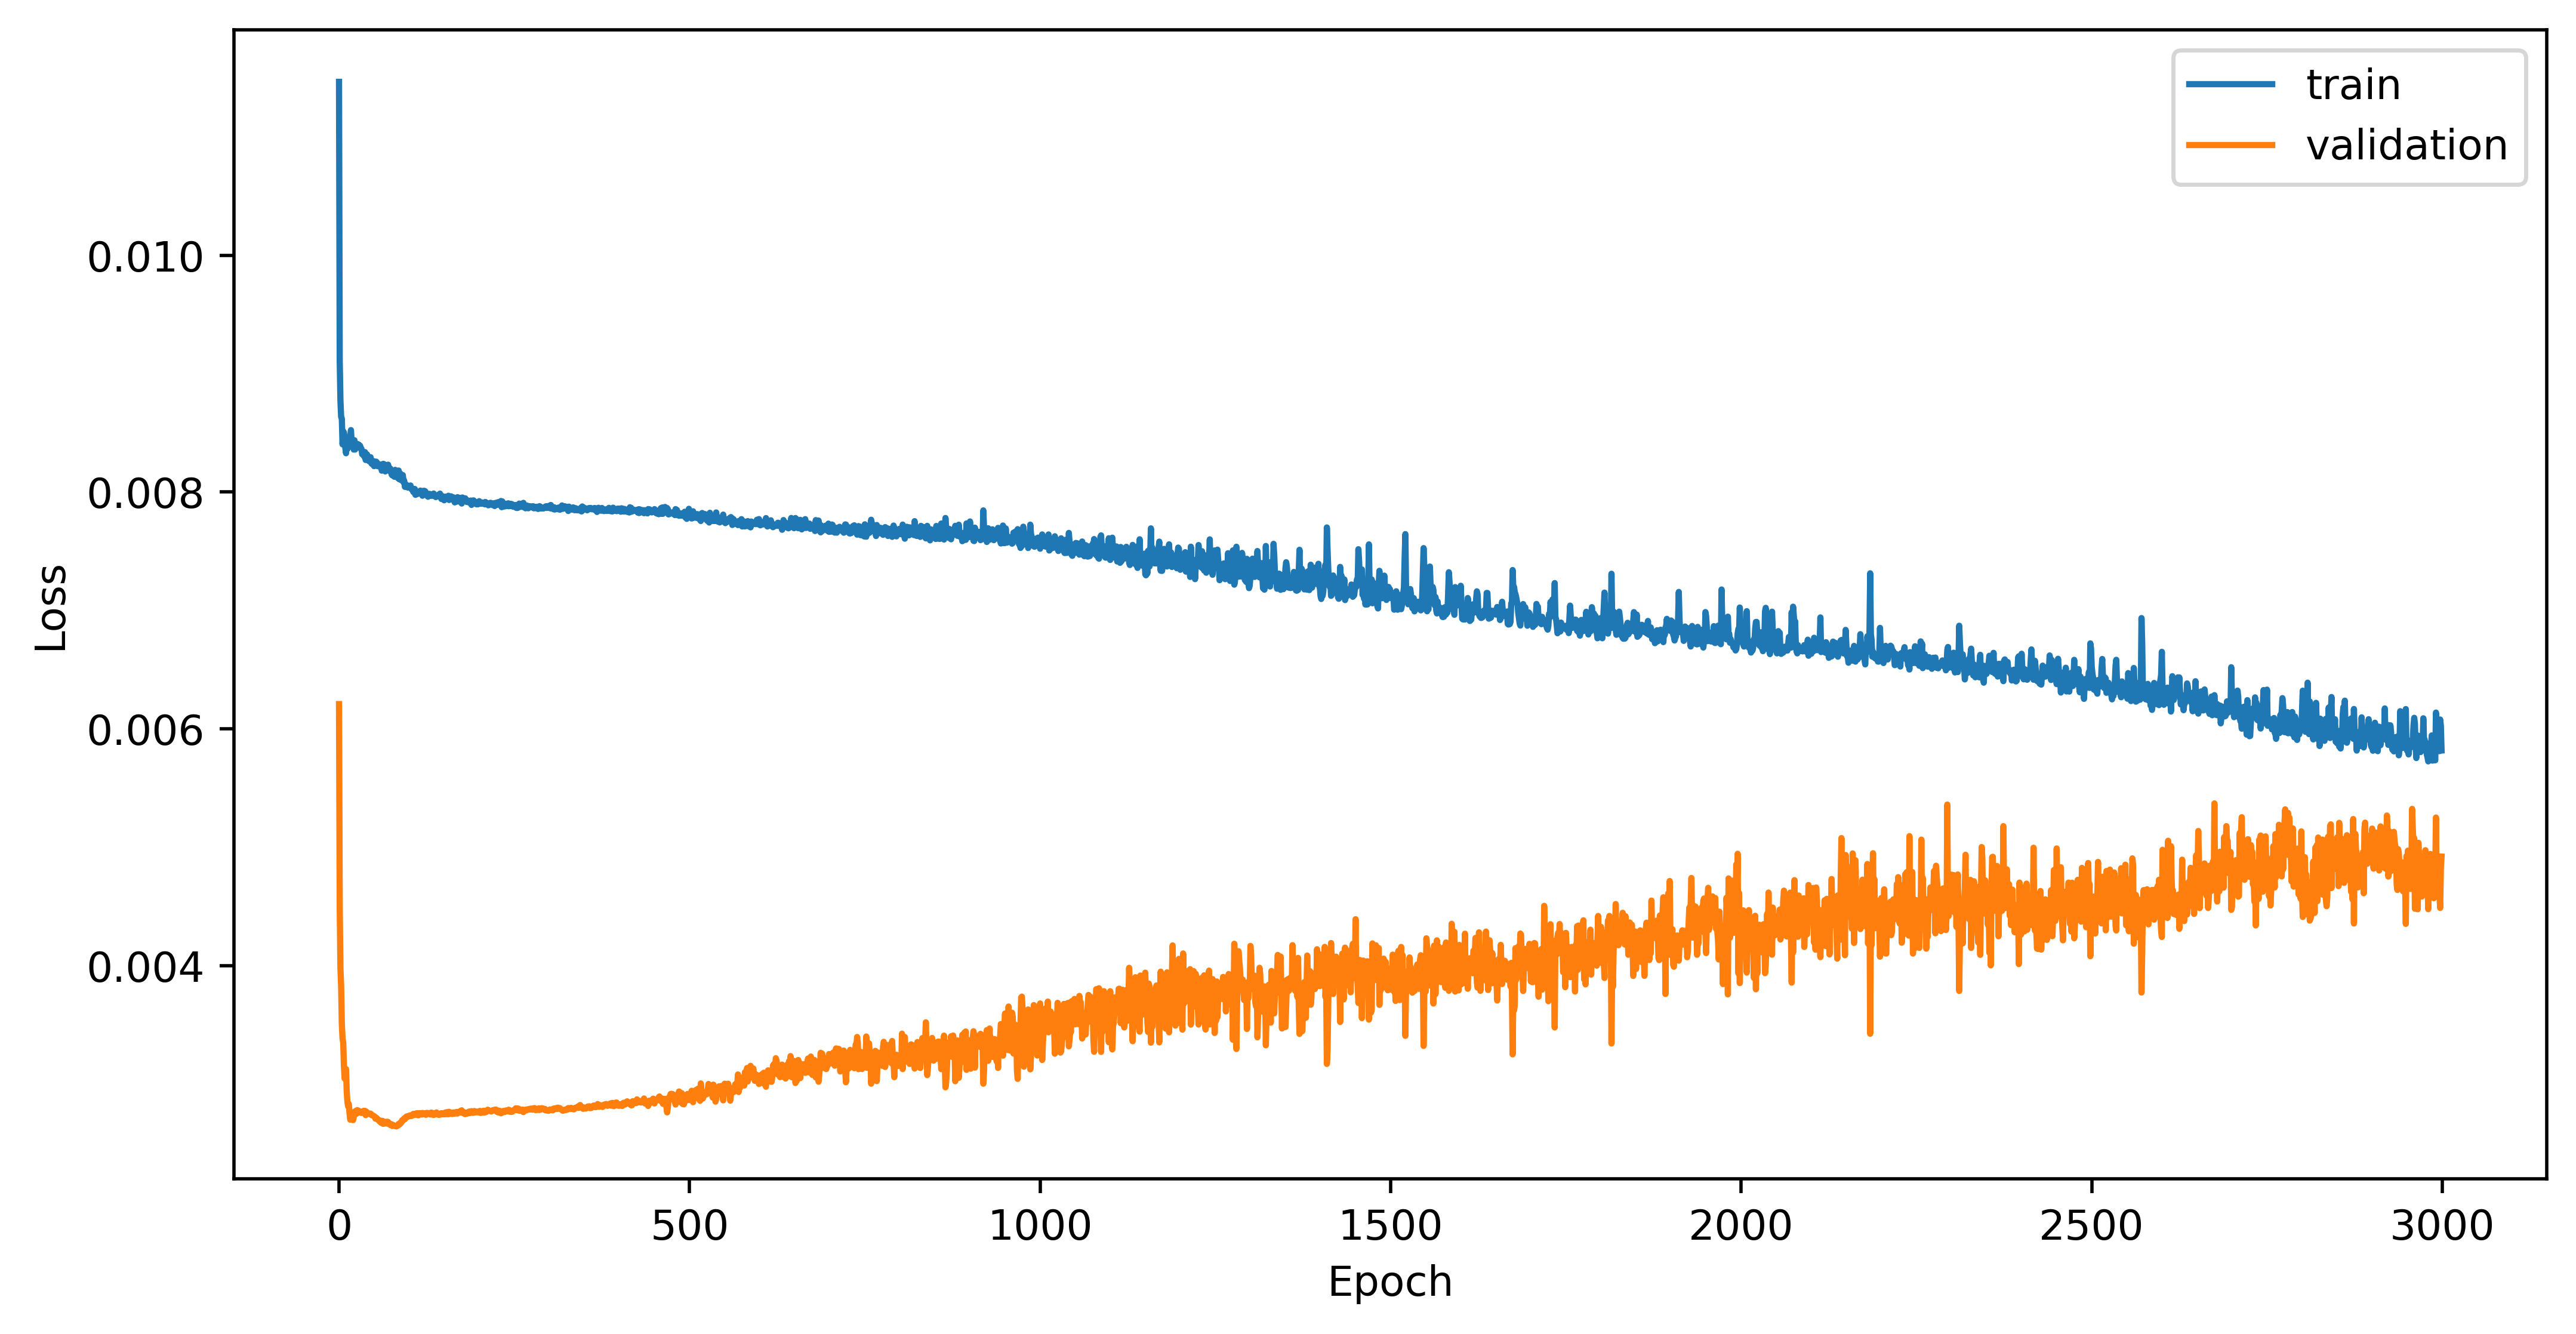

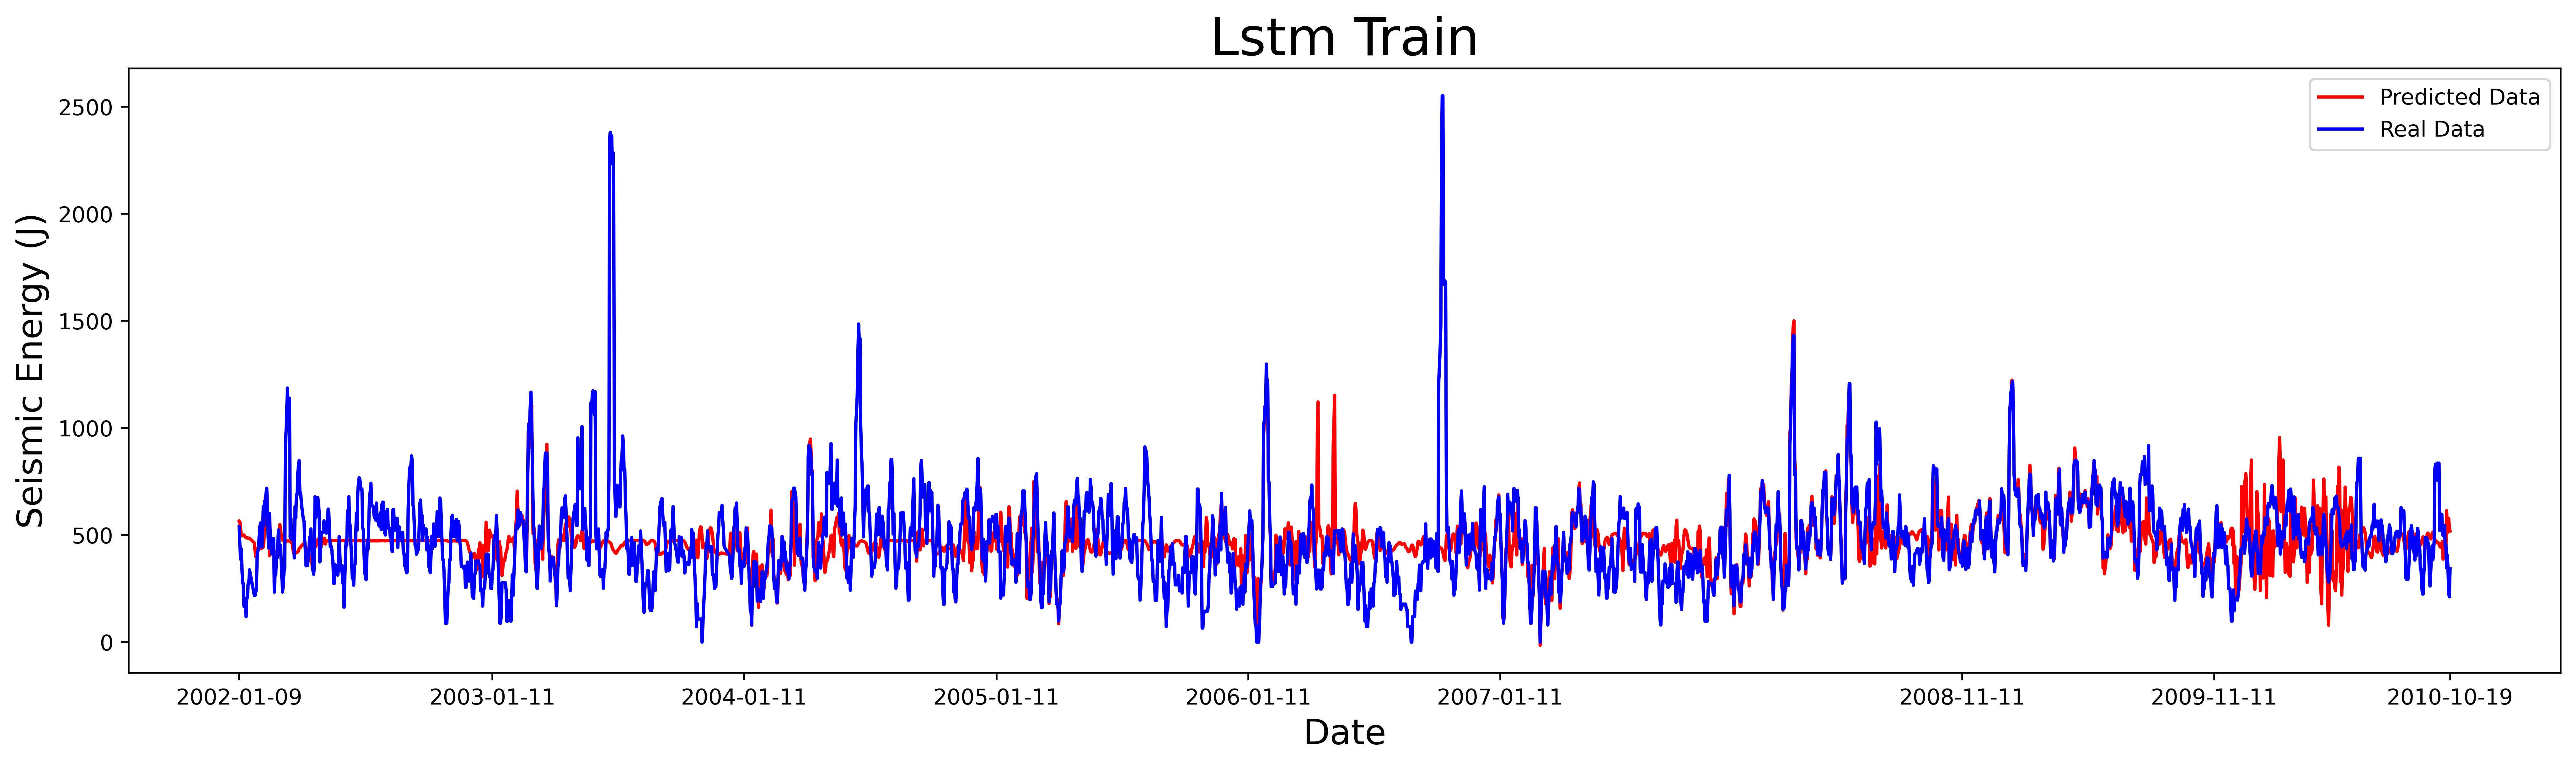

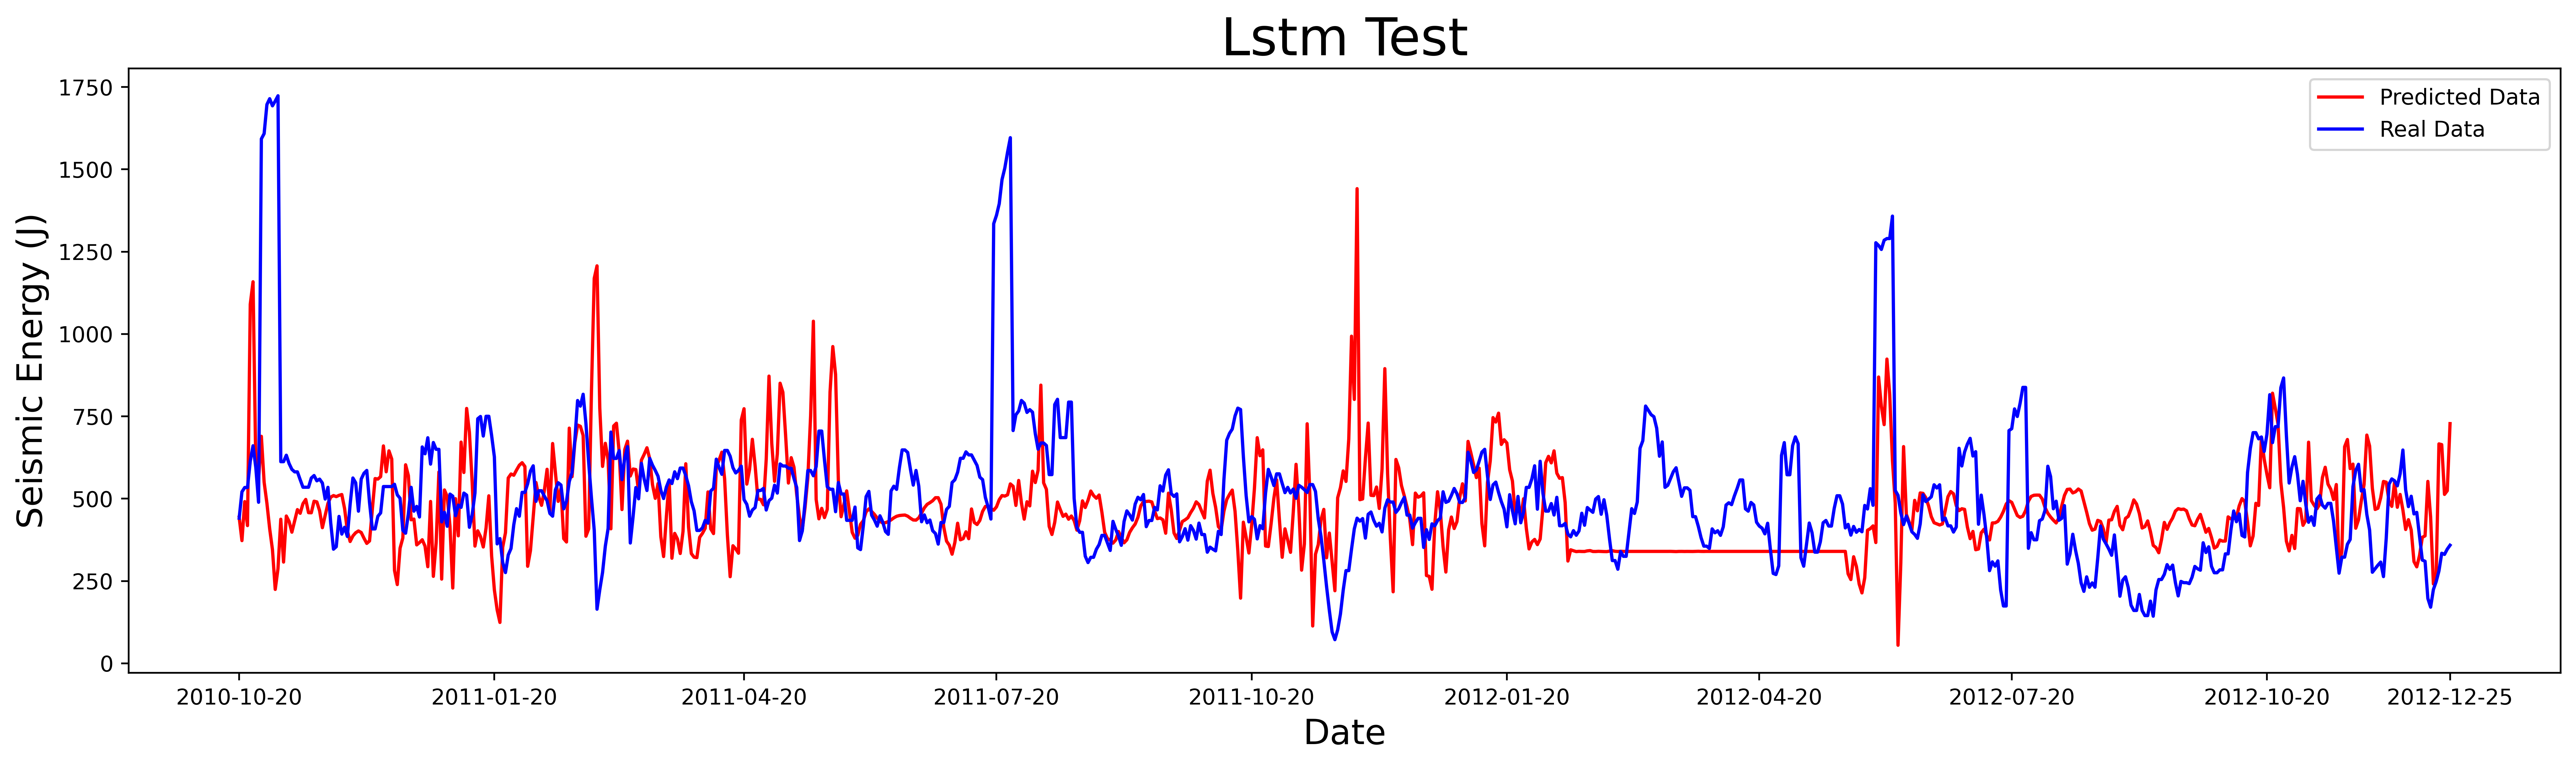

In [9]:
#Tran-test prediction results with plottings
save_location="../graphs/"

plt.figure(figsize=(10,5), dpi=500)
plt.plot(inf.history['loss'])
plt.plot(inf.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig(save_location+"lstm_ysl_loss.jpg",dpi=500,bbox_inches='tight')

plt.figure(figsize=(20,5), dpi=500)
plt.title("Lstm Train", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Seismic Energy (J)", fontsize=16)

ticks = ["2002-01-09", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11", "2008-11-11", "2009-11-11","2010-10-19"]
labels = ["2002-01-09", "2003-01-11", "2004-01-11", "2005-01-11", "2006-01-11", "2007-01-11","2008-11-11","2009-11-11", "2010-10-19"]
ax = plt.gca()

plt.plot(df_collection_efd_energy.index[7:len(output_train_data)+7],trainPredict, c='r', label="Predicted Data")
plt.plot(df_collection_efd_energy.index[7:len(output_train_data)+7],output_train_data, c='b', label="Real Data")
plt.legend()

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)

plt.savefig(save_location+"lstm_train_ysl.jpg",dpi=500,bbox_inches='tight')


plt.figure(figsize=(20,5), dpi=500)
plt.title("Lstm Test", fontsize=24)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Seismic Energy (J)", fontsize=16)


ticks = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-25"]
labels = ["2010-10-20", "2011-01-20", "2011-04-20", "2011-07-20", "2011-10-20", "2012-01-20", "2012-04-20", "2012-07-20", "2012-10-20", "2012-12-25"]
ax = plt.gca()

plt.plot(df_collection_efd_energy.index[len(output_train_data)+7:],testPredict, c='r', label="Predicted Data")
plt.plot(df_collection_efd_energy.index[len(output_train_data)+7:],output_test_data, c='b', label="Real Data")
plt.legend()

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=0)

plt.savefig(save_location+"lstm_test_ysl.jpg",dpi=500,bbox_inches='tight')
